# scRNA-seq analysis for CellOracle using SnapATAC2 spectral dimensionality reduction
**Authorship:** Adam Klie (last updated: 08/03/2023)<br>
***
**Description:** This notebook preprocesses the RNA part of the multi-seq for CellOracle. We will use dimensionality reduction with SnapATAC2 here instead.
***

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
sc.settings.verbosity = 3
import seaborn as sns
from ipywidgets import interactive

random_state = 13

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

In [ ]:
results_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results"
dataset_name = "CharacterizationMcGinnis_Dataset6"

# Load AnnData object
Generated from combining h5 files in `/cellar/users/aklie/data/igvf/topic_grn_links/notebooks/CharacterizationMcGinnis_Dataset6/combinomics_data_wrangling.ipynb`

In [ ]:
# Link to the h5ad file
h5ad_file = "/cellar/users/aklie/data/igvf/topic_grn_links/h5ad/CharacterizationMcGinnis_Dataset6/adata_rna_merged.h5ad"

In [ ]:
# Load using scanpy
adata = sc.read_h5ad(h5ad_file)
adata

AnnData object with n_obs × n_vars = 112128 × 31128
    obs: 'n_genes', 'total_counts', 'duplicate_counts', 'umis', 'genes', 'percent_mitochondrial', 'lane', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.25', 'seurat_clusters', 'PercentMito', 'lane_processded_metadata', 'MULTI', 'RNA_snn_res.1', 'RNA_snn_res.0.5', 'sample', 'temp'
    var: 'gene_ids', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4'

# QC

## Combinomics QCs
These are qc metrics caclulated by the BROAD Combinomics pipeline: https://docs.google.com/presentation/d/1TbIjyVU60mbg-rL8Y7mGiRjvf_7sjTGlrjMMG3i9Cig/edit#slide=id.g255fe6476ff_0_850

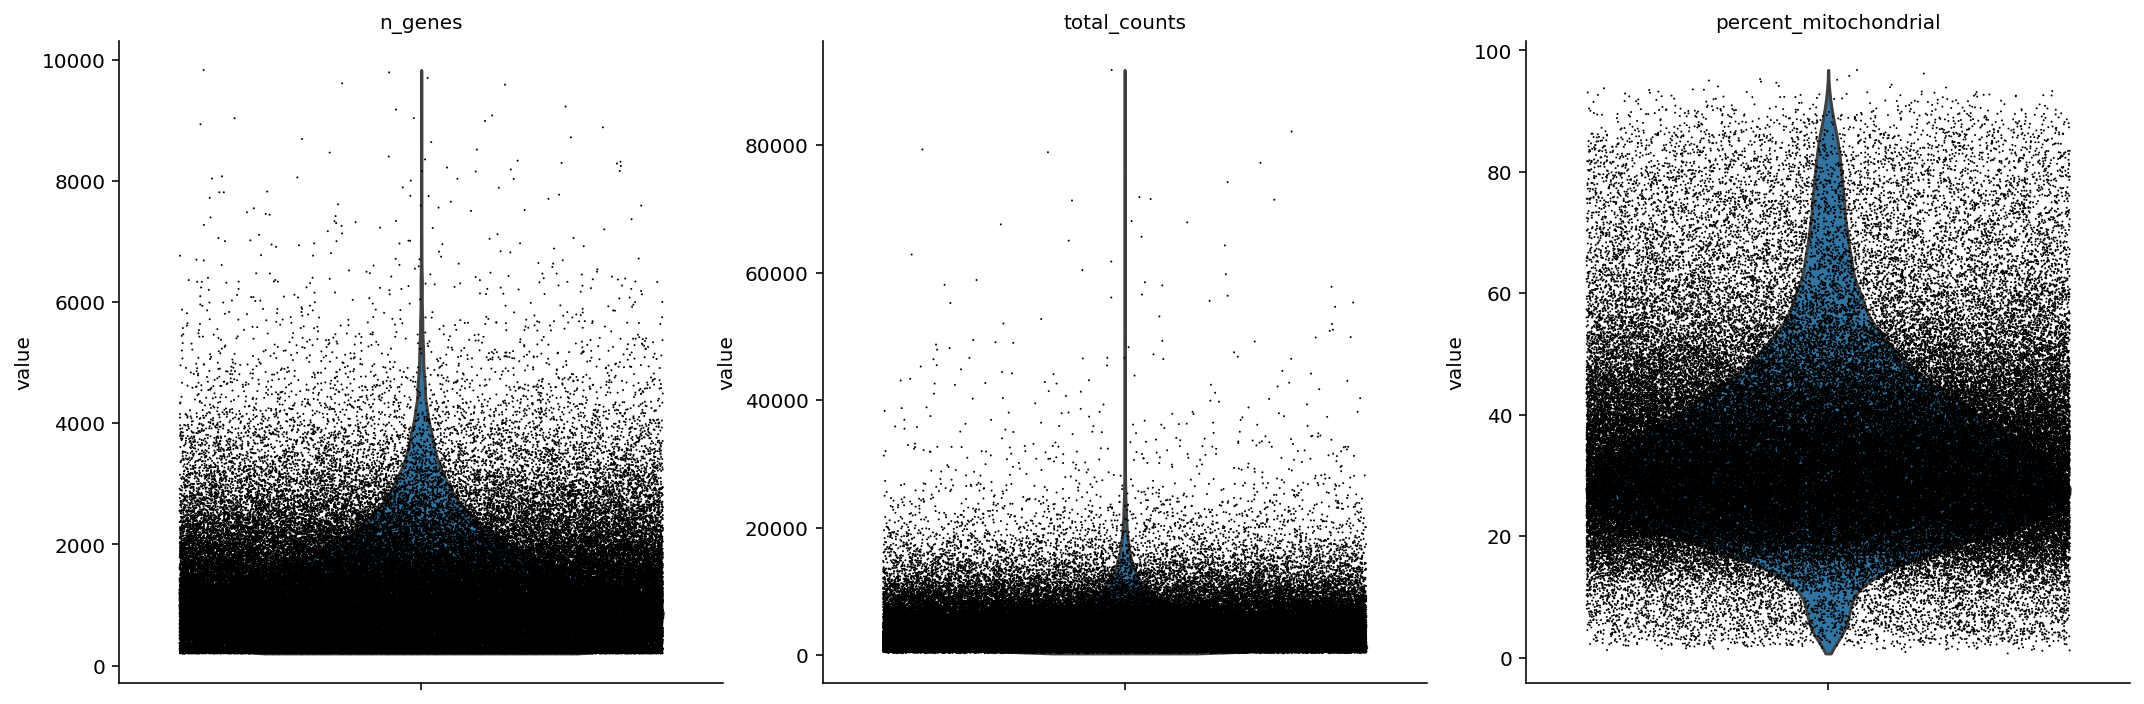

In [ ]:
# Classic 3 violin plots
sc.pl.violin(adata, ['n_genes', 'total_counts', 'percent_mitochondrial'], jitter=0.4, multi_panel=True)

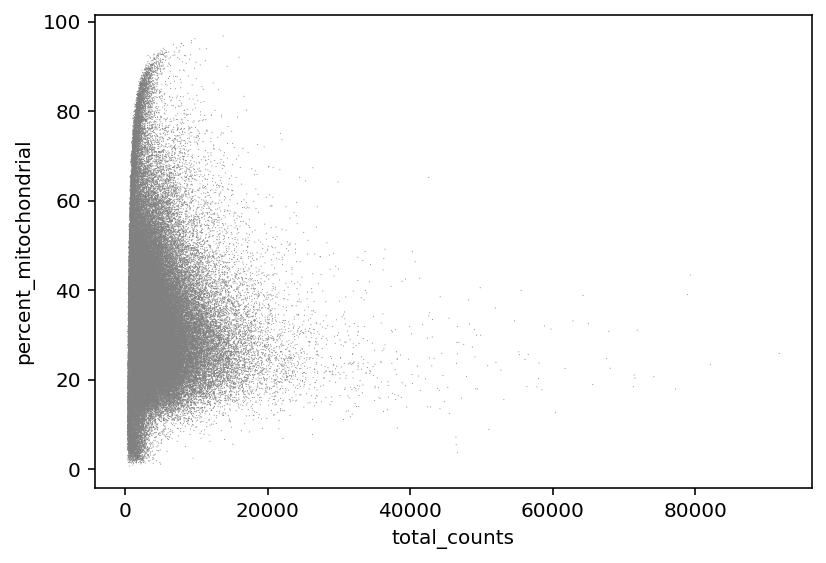

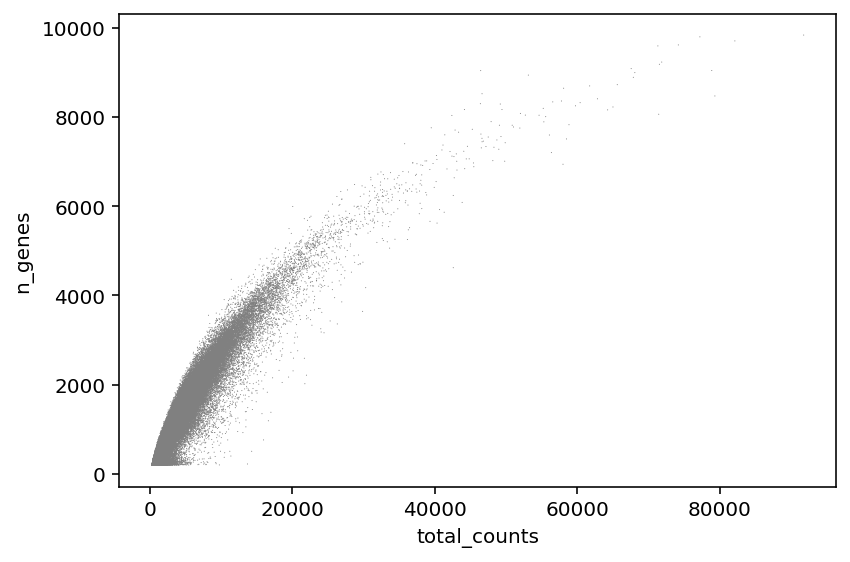

In [ ]:
# Couple scatters
sc.pl.scatter(adata, x='total_counts', y='percent_mitochondrial')
sc.pl.scatter(adata, x='total_counts', y='n_genes')

## Doublet detection
Use scrublet to perform doublet detection. Takes around 5 minutes to run on this dataset. I let scrublet decide on a doublet score threshold here.

In [ ]:
# Run the doublet detection algorithm from scrublet, we have left all the parameters as default, but feel free to play around with them
sce.pp.scrublet(
    adata,
    adata_sim=None,
    random_state=random_state
)

Running Scrublet


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 13.6%
Estimated detectable doublet fraction = 49.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 27.4%
    Scrublet finished (0:05:49)


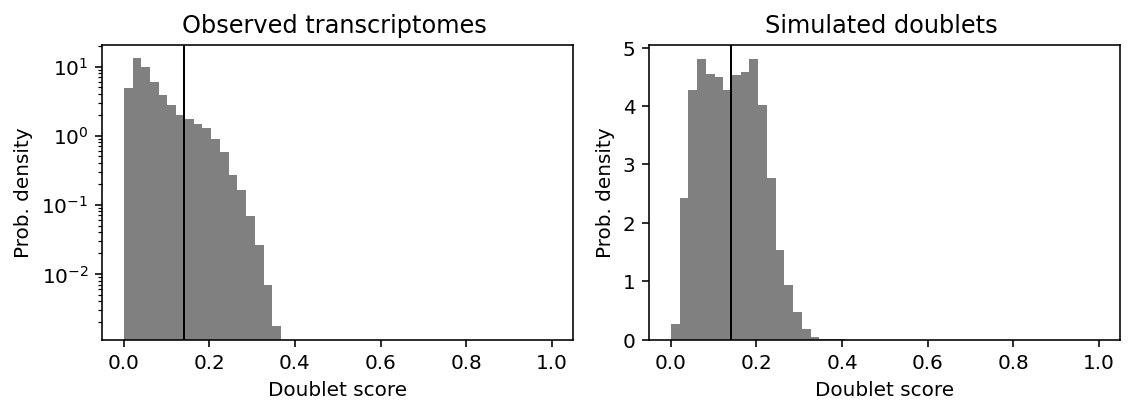

In [ ]:
# Plot the doublet score distribution against simulated cells
sce.pl.scrublet_score_distribution(adata)

# Filtering
Actually filter cells based on QC

In [ ]:
# Generates a nice interactive filtering plot to play with thresholds and see how that effects cells passing QC
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
def h(counts=500, genes=300, mito=25, doublet_score=0.2):
    conditions = [
        (adata.obs['doublet_score'] > doublet_score),
        (adata.obs['total_counts'] < counts),
        (adata.obs['n_genes'] < genes),
        (adata.obs['percent_mitochondrial'] > mito),
        ((adata.obs['doublet_score'] <= doublet_score) & (adata.obs['total_counts'] >= counts) & (adata.obs['n_genes'] >= genes) & adata.obs['percent_mitochondrial'] <= mito)
    ]
    values = ['Doublet', 'Low_nFeature', 'Low_ngenes', 'High_MT', 'Passing']
    adata.obs['QC'] = np.select(conditions, values)
    adata.obs['QC'] = adata.obs['QC'].astype('category')
    new_df1 = pd.DataFrame(adata.obs['QC'].value_counts()).reset_index()
    p = sns.barplot(x='index', y='QC', data=new_df1, color='sandybrown')
    show_values(p)

interactive_plot = interactive(h, counts=(0, 2000,20), genes=(0, 2000,20), mito=(0, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=500, description='counts', max=2000, step=20), IntSlider(value=300, desc…

In [ ]:
# Check the numbers
adata.obs["QC"].value_counts()

High_MT         69974
Passing         28415
Low_ngenes       7888
Doublet          5053
Low_nFeature      798
Name: QC, dtype: int64

In [ ]:
adata.obs[adata.obs["sample"].isna()].value_counts("QC")

QC
High_MT         22958
Passing          6507
Low_ngenes       6120
Doublet          4412
Low_nFeature      470
dtype: int64

In [ ]:
# Check how many cells passed Chris's QC but not mine
pd.crosstab(adata.obs["QC"], adata.obs["sample"], dropna=False)

sample,S1,S3,S4,S5_2D,S5_2D3D,S6_2D,S6_2D3D
QC,,,,,,,
Doublet,52,56,93,105,125,115,95
High_MT,1027,2344,3303,5974,9997,13659,10712
Low_nFeature,18,15,39,83,60,49,64
Low_ngenes,70,72,625,110,276,298,317
Passing,2364,1903,1504,6709,3275,4423,1730


In [ ]:
# Now actually filter the data based on the QC metrics
adata_filtered = adata[adata.obs['QC'] == 'Passing']
#adata_filtered = adata[~adata.obs["sample"].isna()]

In [ ]:
adata_filtered

View of AnnData object with n_obs × n_vars = 71661 × 31128
    obs: 'n_genes', 'total_counts', 'duplicate_counts', 'umis', 'genes', 'percent_mitochondrial', 'lane', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.25', 'seurat_clusters', 'PercentMito', 'lane_processded_metadata', 'MULTI', 'RNA_snn_res.1', 'RNA_snn_res.0.5', 'sample', 'temp', 'doublet_score', 'predicted_doublet', 'QC'
    var: 'gene_ids', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4'
    uns: 'scrublet'

# Normalization

In [ ]:
# Keep raw cont data before log transformation
adata_filtered.raw = adata_filtered
adata_filtered.layers["raw_counts"] = adata_filtered.raw.X.copy()

In [ ]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata_filtered, counts_per_cell_after=1e4)
sc.pp.log1p(adata_filtered)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [ ]:
adata_filtered.layers["log_normalized_counts"] = adata_filtered.X

In [ ]:
adata_filtered.X[:10, :10].todense()

matrix([[0.       , 0.       , 0.       , 0.       , 1.2525845,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 1.2312236,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 1.5302333,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.

# Cell cycle scoring

In [ ]:
# From Regev paper, wonder if this needs updating
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM7','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
           'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
           'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
           'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8']
g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B',
             'MKI67','TMPO','CENPF','TACC3','PIMREG','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1',
             'KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','JPT1','CDC20','TTK','CDC25C',
             'KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1',
             'ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
cell_cycle_genes = s_genes + g2m_genes
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
len(cell_cycle_genes)

97

In [ ]:
# Score cells based on these genes, might be useful later
sc.tl.score_genes_cell_cycle(adata_filtered, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'S_score', score of gene set (adata.obs).
    472 total control genes are used. (0:00:01)
computing score 'G2M_score'


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    514 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


# Highly variable genes

In [ ]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata_filtered.X, flavor='cell_ranger', n_top_genes=2000, log=False)

# Subset the genes
adata_variable = adata_filtered[:, filter_result.gene_subset]

extracting highly variable genes
    finished (0:00:01)
